In [ ]:
# add default values for parameters here

In [1]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

import datetime
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

2022-12-13 20:42:03.490695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 20:42:03.593722: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-13 20:42:03.598201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 20:42:03.598217: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# 데이터 생성, 처리
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

def date_cut_day(dataframe_date_timestamp):
    dataframe_date_timestamp = datetime.datetime.strftime(dataframe_date_timestamp, "%Y-%m-%d")
    return dataframe_date_timestamp

def train_test_result(dir, stock, variable, window_size):
    #score data 뽑기
    score = pd.read_csv(dir)
    score.columns = ["Date", "Score"]
    
    #price data 뽑기
    price_data = yf.download([stock],start = '2012-01-01', end = "2022-05-01")
    
    opening = price_data.index.copy()
    opening = pd.DataFrame(opening)
    opening["opening_date"] = 1
    opening.Date = opening.Date.apply(lambda x: date_cut_day(x))
    
    Date = pd.date_range(start='20111230', end='20220430')
    Date = pd.DataFrame({"Date" : Date.values})
    Date.Date = Date.Date.apply(lambda x: date_cut_day(x))

    
    set_news_data_date = pd.merge(Date, opening, how ="left",left_on='Date', right_on = "Date") 
    set_news_data_date = set_news_data_date.where(pd.notnull(set_news_data_date), 0) 
    set_news_data_date.Date = set_news_data_date.Date.apply(lambda x: pd.to_datetime(x, errors="ignore"))

    standard=set_news_data_date.Date.iloc[len(set_news_data_date)-1] + datetime.timedelta(days=1)
    set_news_data_date["price_date"]=0
    for i in range(len(set_news_data_date)-1,-1,-1):
        if i==(len(set_news_data_date)-1):
            standard = set_news_data_date.Date[i]
            set_news_data_date.price_date[i]=standard  + datetime.timedelta(days=1)
        elif (set_news_data_date.opening_date[i]==1)&(set_news_data_date.opening_date[i+1]==1):
            standard = set_news_data_date.Date[i]
            set_news_data_date.price_date[i]=standard  + datetime.timedelta(days=1)
        elif (i!=0):
            if((set_news_data_date.opening_date[i]==1)&(set_news_data_date.opening_date[i+1]==0)&(set_news_data_date.opening_date[i-1]==0)):
                set_news_data_date.price_date[i]=standard  + datetime.timedelta(days=1)
                standard = set_news_data_date.Date[i]
            else:
                set_news_data_date.price_date[i]=standard
        else:
            set_news_data_date.price_date[i]=standard
    
    set_news_data_date.Date = set_news_data_date.Date.apply(lambda x: date_cut_day(x))
    
    score = pd.merge(set_news_data_date,score, how ="left",on = "Date")
    
    score = score[['Date','Score', "price_date"]]
    score = score.groupby('price_date').mean({"Score"})
    score = score[score.index<="2022-04-29"]

    first_data = yf.download([stock],start = '2011-12-30', end = '2012-01-01')
    
    price_data = price_data.reset_index()
    score = score.reset_index()
    score.columns = ["Date", "Score"]
    
    #price data와 score data 결합
    price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","Score"]]

    #뉴스가 없는 날은 즉, score가 없는 날은 중립의 의미로 0으로 처리
    price_data.Score[price_data.Score.isnull()]=0

    #전날 종가의 영향을 받으므로 전날 종가 변수를 생성
    price_data["before_close"] = 0
    price_data = price_data.reset_index(drop=True)
    for i in range(len(price_data)-1):
        price_data.before_close[i+1] = price_data.Close[i]
    
    price_data.before_close[0] = first_data["Close"][0]

    # minmaxscaler 사용
    price_data.columns = ["Close","Open","Score","before_close"]
    
    x = price_data[variable]
    y = price_data[["Close"]]
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x = pd.DataFrame(scaler_x.fit_transform(x))
    y = pd.DataFrame(scaler_y.fit_transform(y))
    
    x.columns = variable
    y.columns = ["Close"]

    train_index = int(len(x)*0.7)

    train_x = x.iloc[0:train_index]
    test_x = x.iloc[train_index:len(x)]

    train_y = y.iloc[0:train_index]
    test_y = y.iloc[train_index:len(y)]

    train_x = train_x.to_numpy().reshape(train_x.shape[0],1,train_x.shape[1])
    train_y = train_y.to_numpy().reshape(train_y.shape[0],train_y.shape[1])
    test_x = test_x.to_numpy().reshape(test_x.shape[0],1,test_x.shape[1])
    test_y = test_y.to_numpy().reshape(test_y.shape[0],test_y.shape[1])
    
    #window size에 맞게 데이터 설정
    x = np.zeros(shape=(train_x.shape[0]-window_size+1,window_size,x.shape[1]))
    for i in range(train_x.shape[0]-window_size+1):
        x[i]=np.vstack((train_x[i:i+window_size]))

    y = train_y[window_size-1:train_x.shape[0]]

    x_t = np.zeros(shape=(test_x.shape[0]-window_size+1,window_size,x.shape[2]))
    for i in range(test_x.shape[0]-window_size+1):
        x_t[i]=np.vstack((test_x[i:i+window_size]))
    
    y_t = test_y[window_size-1:test_x.shape[0]]
    
    return x, y, x_t, y_t


# 1. SVR

`-` The optimization of share price prediction model based on support vector machine 사용

`-` 위 논문에서 SVR이 kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01 일 때 최적화 되었다고 소개

`-` 문제 : 하루 전 데이터의 양상을 거의 동일하게 따라함. 즉, t-1일 주가 데이터를 t일의 예측데이터로 사용한 것과 비슷

In [3]:
import warnings
warnings.filterwarnings('ignore')


# price data, window = 1
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:

x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

model = SVR(kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01)
model.fit(x, y)
    
#예측값
svr_pred = np.reshape(model.predict(x_t),(len(model.predict(x_t)),1))
    
svr_mae = mean_absolute_error(y_t, svr_pred)
svr_mse = mean_squared_error(y_t, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_t, svr_pred))

In [5]:
svr_rmse, svr_mse, svr_mae

(0.03042982906670776, 0.0009259744970290524, 0.02258301243725792)

# 2. ARIMA

`-` stock price prediction using BERT and GAN 사용

`-` 메일을 했으나 답이오지않아 정확히 카피는 불가하여 closing price와 arima모형만을 가져와 실습

`-` ARIMA(4,1,0) 사용

`-` 문제 : 하루 전 데이터의 양상을 거의 동일하게 따라함. 즉, t-1일 주가 데이터를 t일의 예측데이터로 사용한 것과 비슷

In [8]:
import warnings
warnings.filterwarnings('ignore')


# price data, window = 1
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

train = pd.DataFrame(x)
test = pd.DataFrame(x_t)

# 데이터프레임 펴주기
train = train.squeeze()
test = test.squeeze()

# 주가데이터
history = [i for i in train]

In [10]:
x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

train = pd.DataFrame(x)
test = pd.DataFrame(x_t)

# 데이터프레임 펴주기
train = train.squeeze()
test = test.squeeze()

# 주가데이터
history = [i for i in train]
    
# 예측데이터
arima_pred = list()
    
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    forecast_test = model_fit.forecast()
    yhat = forecast_test[0]
    arima_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    
    
arima_pred = pd.DataFrame(arima_pred)
arima_pred.index = test.index
'''
fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(predictions, label='predict value')
plt.plot(y, label='True value')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(arima_pred[100:150])
plt.plot(test[100:150])
'''

"\nfig = plt.figure(figsize=(12,6))\nplt.subplot(1, 2, 1)\nplt.plot(predictions, label='predict value')\nplt.plot(y, label='True value')\nplt.legend()\nplt.subplot(1, 2, 2)\nplt.plot(arima_pred[100:150])\nplt.plot(test[100:150])\n"

In [11]:
arima_mae = mean_absolute_error(y_t, arima_pred)
arima_mse = mean_squared_error(y_t, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(y_t, arima_pred))
arima_rmse, arima_mse, arima_mae

(0.018428073673531976, 0.00033959389931712236, 0.01328510774015906)

# 3. Bi-LSTM

`-` stock price prediction using BERT and GAN 사용

In [60]:
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
bi_lstm_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = bi_lstm_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
bi_lstm_pred = bi_lstm_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/150
23/23 [==============================] - 7s 148ms/step - loss: 0.0583 - mse: 0.0053 - mae: 0.0518 - val_loss: 0.0350 - val_mse: 0.0014 - val_mae: 0.0333
Epoch 2/150
23/23 [==============================] - 2s 109ms/step - loss: 0.0148 - mse: 2.3388e-04 - mae: 0.0125 - val_loss: 0.0260 - val_mse: 7.4798e-04 - val_mae: 0.0245
Epoch 3/150
23/23 [==============================] - 2s 107ms/step - loss: 0.0093 - mse: 8.9467e-05 - mae: 0.0076 - val_loss: 0.0138 - val_mse: 2.1775e-04 - val_mae: 0.0118
Epoch 4/150
23/23 [==============================] - 2s 109ms/step - loss: 0.0074 - mse: 5.5534e-05 - mae: 0.0059 - val_loss: 0.0113 - val_mse: 1.5999e-04 - val_mae: 0.0094
Epoch 5/150
23/23 [==============================] - 2s 108ms/step - loss: 0.0075 - mse: 5.7341e-05 - mae: 0.0061 - val_loss: 0.0102 - val_mse: 1.1810e-04 - val_mae: 0.0083
Epoch

In [61]:
bi_lstm_pred

[0.10104423761367798, 0.016885599121451378, 0.09950421005487442]

In [17]:
dir_model = "/home/whfhrs3260/model/"
#bi_lstm_model.save(dir_model + 'bi_lstm_128_64_window30_10years_Apple.h5')

# 4. LSTM

`-` stock price prediction using BERT and GAN 에서 Bi-LSTM을 LSTM으로 변경해 실습

In [62]:
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_1_model = Sequential()
lstm_1_model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_1_model.add(Dropout(0.2))
lstm_1_model.add((LSTM(64)))
lstm_1_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
lstm_1_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_1_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
lstm_1_pred = lstm_1_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/150
23/23 [==============================] - 4s 106ms/step - loss: 0.0377 - mse: 0.0020 - mae: 0.0317 - val_loss: 0.0129 - val_mse: 2.2086e-04 - val_mae: 0.0109
Epoch 2/150
23/23 [==============================] - 2s 84ms/step - loss: 0.0135 - mse: 2.0213e-04 - mae: 0.0115 - val_loss: 0.0118 - val_mse: 1.7662e-04 - val_mae: 0.0098
Epoch 3/150
23/23 [==============================] - 2s 85ms/step - loss: 0.0086 - mse: 7.4656e-05 - mae: 0.0068 - val_loss: 0.0111 - val_mse: 1.4555e-04 - val_mae: 0.0090
Epoch 4/150
23/23 [==============================] - 2s 84ms/step - loss: 0.0083 - mse: 7.2074e-05 - mae: 0.0068 - val_loss: 0.0117 - val_mse: 1.4207e-04 - val_mae: 0.0095
Epoch 5/150
23/23 [==============================] - 2s 84ms/step - loss: 0.0068 - mse: 4.7142e-05 - mae: 0.0055 - val_loss: 0.0126 - val_mse: 1.6107e-04 - val_mae: 0.0105
Epoch

In [63]:
lstm_1_pred

[0.06980745494365692, 0.008565286174416542, 0.06803356856107712]

In [68]:
lstm_1_model.save(dir_model + 'lstm_128_64_window30_10years_Apple.h5')

In [21]:
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_1_model = Sequential()
lstm_1_model.add(LSTM(64, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_1_model.add(Dropout(0.2))
lstm_1_model.add((LSTM(32,return_sequences=True)))
lstm_1_model.add(Dropout(0.2))
lstm_1_model.add((LSTM(32)))
lstm_1_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
lstm_1_model.compile(optimizer="adam", loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_1_model.fit(x, y, epochs=200, batch_size=128, validation_split=0.2)
    
lstm_1_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
12/12 [==============================] - 5s 180ms/step - loss: 0.0556 - mse: 0.0034 - mae: 0.0460 - val_loss: 0.1162 - val_mse: 0.0139 - val_mae: 0.1145
Epoch 2/200
12/12 [==============================] - 1s 107ms/step - loss: 0.0380 - mse: 0.0015 - mae: 0.0312 - val_loss: 0.0926 - val_mse: 0.0089 - val_mae: 0.0911
Epoch 3/200
12/12 [==============================] - 1s 108ms/step - loss: 0.0261 - mse: 7.0004e-04 - mae: 0.0216 - val_loss: 0.0332 - val_mse: 0.0012 - val_mae: 0.0309
Epoch 4/200
12/12 [==============================] - 1s 107ms/step - loss: 0.0147 - mse: 2.2364e-04 - mae: 0.0120 - val_loss: 0.0302 - val_mse: 9.6376e-04 - val_mae: 0.0280
Epoch 5/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0117 - mse: 1.3944e-04 - mae: 0.0092 - val_loss: 0.0172 - val_mse: 3.1444e-04 - val_mae: 0.0147
Epoch 6/200
12/12

[0.0961637943983078, 0.01548788696527481, 0.09442652761936188]

`-` Stock Price Prediction Based on LSTM Neural Network : the Effectiveness of News Sentiment Analysis 사용

In [64]:
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = Sequential()
lstm_2_model.add(LSTM(50, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_2_model.add((LSTM(50)))
lstm_2_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
lstm_2_model.compile(optimizer="adam", loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_2_model.fit(x, y, epochs=40, batch_size=128, validation_split=0.2)
    
lstm_2_pred = lstm_2_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/40
12/12 [==============================] - 3s 57ms/step - loss: 0.0576 - mse: 0.0035 - mae: 0.0473 - val_loss: 0.1298 - val_mse: 0.0172 - val_mae: 0.1278
Epoch 2/40
12/12 [==============================] - 0s 10ms/step - loss: 0.0410 - mse: 0.0017 - mae: 0.0345 - val_loss: 0.1139 - val_mse: 0.0133 - val_mae: 0.1115
Epoch 3/40
12/12 [==============================] - 0s 12ms/step - loss: 0.0394 - mse: 0.0016 - mae: 0.0330 - val_loss: 0.1285 - val_mse: 0.0169 - val_mae: 0.1265
Epoch 4/40
12/12 [==============================] - 0s 12ms/step - loss: 0.0389 - mse: 0.0015 - mae: 0.0322 - val_loss: 0.1199 - val_mse: 0.0147 - val_mae: 0.1178
Epoch 5/40
12/12 [==============================] - 0s 12ms/step - loss: 0.0380 - mse: 0.0014 - mae: 0.0318 - val_loss: 0.1183 - val_mse: 0.0143 - val_mae: 0.1162
Epoch 6/40
12/12 [=============================

In [65]:
lstm_2_pred

[0.04446840658783913, 0.003973251674324274, 0.04220228269696236]

In [69]:
lstm_2_model.save(dir_model + 'lstm_50_50_window1_10years_Apple.h5')

# 5. GRU

In [66]:
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = Sequential()
gru_model.add(GRU(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32))
gru_model.add(Dense(1))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
adam = optimizers.Adam(lr=0.0005)
gru_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = gru_model.fit(x, y, epochs=200, batch_size=128, validation_split=0.2)
    
gru_pred = gru_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
12/12 [==============================] - 4s 144ms/step - loss: 0.0665 - mse: 0.0046 - mae: 0.0529 - val_loss: 0.0970 - val_mse: 0.0098 - val_mae: 0.0950
Epoch 2/200
12/12 [==============================] - 1s 99ms/step - loss: 0.0428 - mse: 0.0019 - mae: 0.0349 - val_loss: 0.0852 - val_mse: 0.0074 - val_mae: 0.0843
Epoch 3/200
12/12 [==============================] - 1s 100ms/step - loss: 0.0277 - mse: 7.8114e-04 - mae: 0.0221 - val_loss: 0.0229 - val_mse: 5.5033e-04 - val_mae: 0.0217
Epoch 4/200
12/12 [==============================] - 1s 101ms/step - loss: 0.0193 - mse: 3.7339e-04 - mae: 0.0153 - val_loss: 0.0177 - val_mse: 3.2349e-04 - val_mae: 0.0160
Epoch 5/200
12/12 [==============================] - 1s 101ms/step - loss: 0.0181 - mse: 3.3066e-04 - mae: 0.0145 - val_loss: 0.0167 - val_mse: 2.9355e-04 - val_mae: 0.0153
Epoch 6/200
12

In [67]:
gru_pred

[0.023519378155469894, 0.0006888242205604911, 0.02033054828643799]

In [31]:
#gru_model.save(dir_model + 'gru_128_64_32_window30_10years_Apple.h5')

# Prediction

In [73]:
from keras.models import load_model

# Bi-LSTM

dir_model = "/home/whfhrs3260/model/"
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = load_model(dir_model + 'bi_lstm_128_64_window30_10years_Apple.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
bi_lstm_pred = bi_lstm_model.predict(x_t)
bi_lstm_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
24/24 [==============================] - 1s 24ms/step - loss: 0.0827 - mse: 0.0114 - mae: 0.0809


[0.08269108831882477, 0.011386033147573471, 0.08090438693761826]

In [70]:
# LSTM_1
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)
lstm_1_model = load_model(dir_model + 'lstm_128_64_window30_10years_Apple.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_1_pred = lstm_1_model.predict(x_t)
lstm_1_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
24/24 [==============================] - 1s 19ms/step - loss: 0.0698 - mse: 0.0086 - mae: 0.0680


[0.06980745494365692, 0.008565286174416542, 0.06803356856107712]

In [71]:
# LSTM_2
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = load_model(dir_model + 'lstm_50_50_window1_10years_Apple.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_2_pred = lstm_2_model.predict(x_t)
lstm_2_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
25/25 [==============================] - 1s 3ms/step - loss: 0.0445 - mse: 0.0040 - mae: 0.0422


[0.04446840658783913, 0.003973251674324274, 0.04220228269696236]

In [72]:
# GRU
dir = "/home/whfhrs3260/csv_data/price_data_score_10years.csv"
stock = "AAPL"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = load_model(dir_model + 'gru_128_64_32_window30_10years_Apple.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
gru_pred = gru_model.predict(x_t)
gru_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
24/24 [==============================] - 1s 17ms/step - loss: 0.0145 - mse: 2.5501e-04 - mae: 0.0114


[0.014479393139481544, 0.0002550109347794205, 0.011379094794392586]

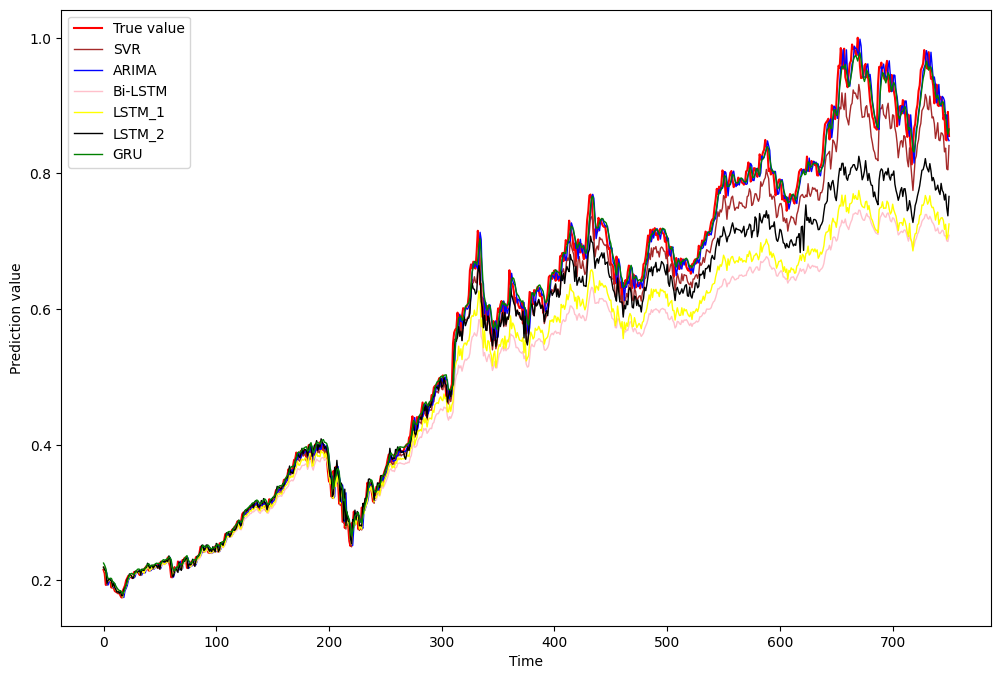

In [74]:
# 모든 모델 그래프
plt.figure(figsize=(12,8))
plt.plot(y_t, label = "True value", color = "red", linewidth=1.5)
plt.plot(svr_pred[29:len(svr_pred)], label= "SVR", color = "brown", linewidth = 1)
plt.plot(arima_pred[29:len(arima_pred)].reset_index(drop=True), label = "ARIMA", color = "blue", linewidth = 1)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1)
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()

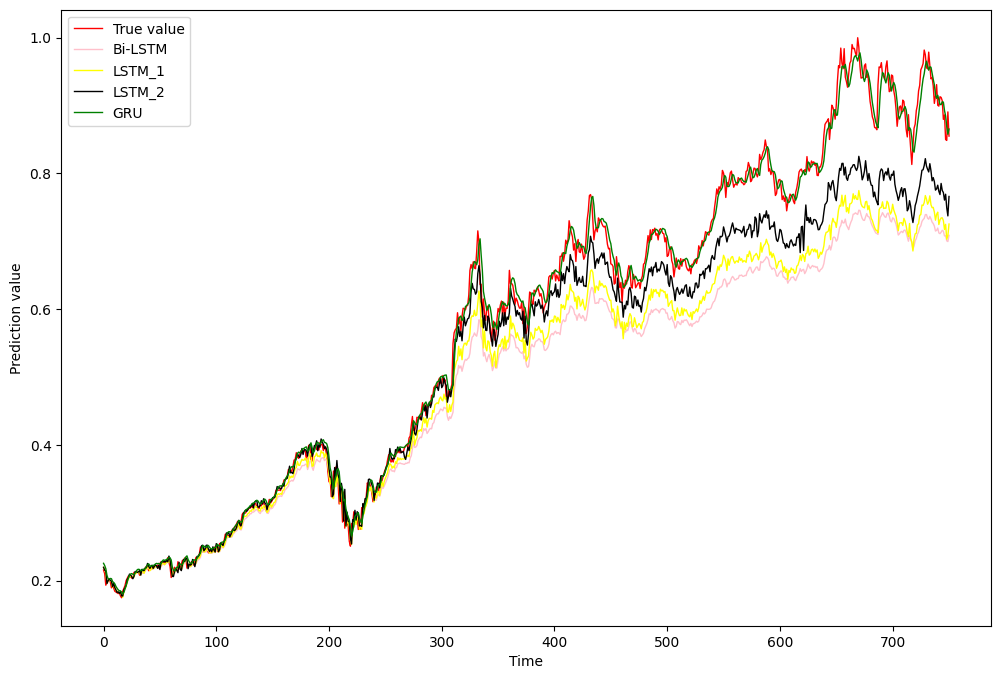

In [75]:
# ARIMA, SVR을 제외한 모델 그래프
plt.figure(figsize=(12,8))
plt.plot(y_t, label = "True value", color = "red", linewidth=1)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1)
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()

# 전날 종가를 오늘 날의 종가라로 예측한 결과

In [76]:
price_data = yf.download("AAPL",start = '2011-12-30', end = "2022-05-01")[["Close"]]
price_data["Predict"] = 0

[*********************100%***********************]  1 of 1 completed


In [77]:
price_data.Predict[1:len(price_data)] = price_data.Close[0:len(price_data)-1]
price_data = price_data.iloc[1:len(price_data)]

In [78]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y_true = pd.DataFrame(scaler_x.fit_transform(price_data[["Close"]]))
y_pred = pd.DataFrame(scaler_y.fit_transform(price_data[["Predict"]]))    

y_true.columns = ["Close"]
y_pred.columns = ["Predict"]

train_index = int(len(y_true)*0.7)

train_true = y_true.iloc[0:train_index]
test_true = y_true.iloc[train_index:len(y_true)]

train_predict = y_pred.iloc[0:train_index]
test_predict = y_pred.iloc[train_index:len(y_pred)]

In [79]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

root_mean_squared_error(test_true.Close, test_predict.Predict)

<tf.Tensor: shape=(), dtype=float64, numpy=0.013384381981088002>

In [80]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_true.Close, test_predict.Predict)

0.009385796053592936

In [81]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(test_true.Close, test_predict.Predict)

0.00017914168101567317

In [ ]:
test_predict = test_predict.reset_index(drop=True)

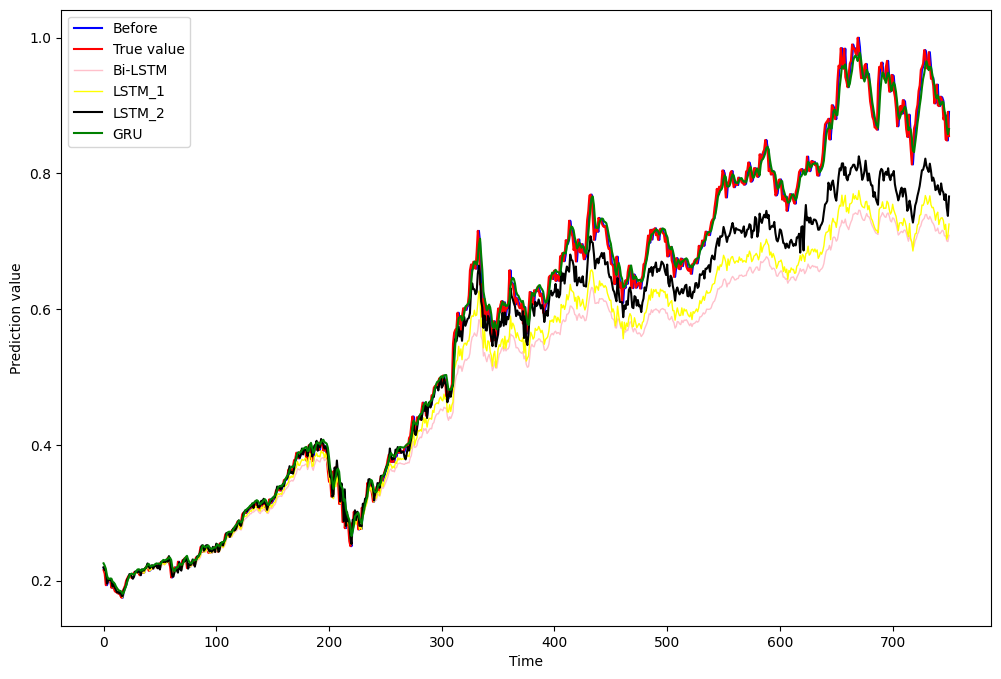

In [88]:
plt.figure(figsize=(12,8))
plt.plot(test_predict.Predict[29:len(lstm_2_pred)].reset_index(drop=True), label= "Before", color = "blue", linewidth=1.5)
plt.plot(y_t, label = "True value", color = "red", linewidth=1.5)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black")
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1.5)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()

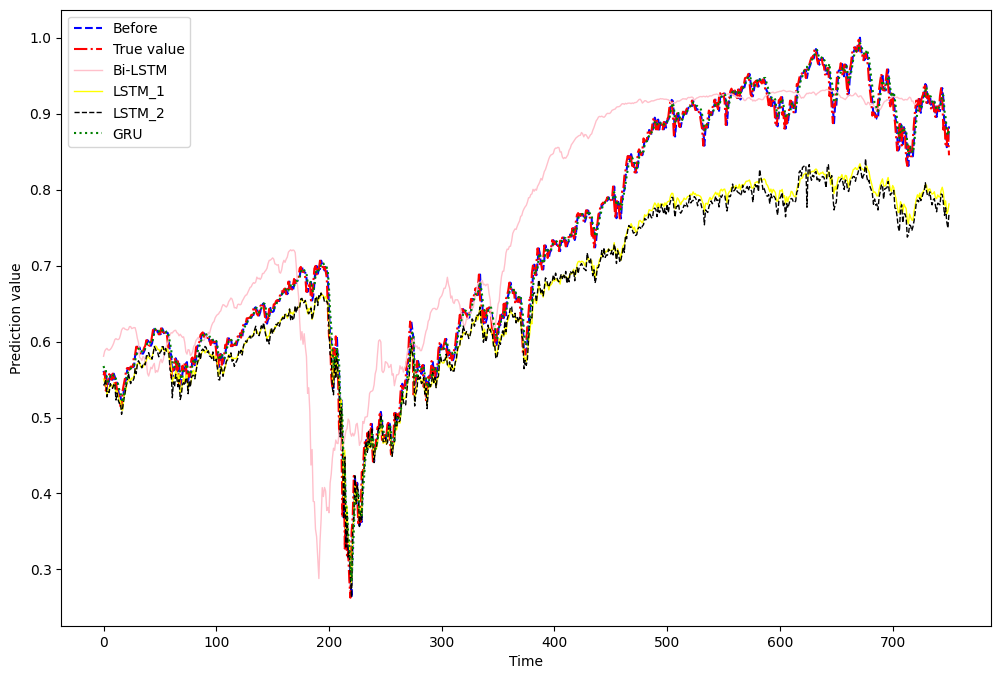

In [169]:
plt.figure(figsize=(12,8))
plt.plot(test_predict.Predict[29:len(lstm_2_pred)].reset_index(drop=True), label= "Before", color = "blue", linewidth=1.5, linestyle='dashed')
plt.plot(y_t[29:len(lstm_2_pred)], label = "True value", color = "red", linewidth=1.5, linestyle='dashdot')
plt.plot(bi_lstm_pred[29:len(lstm_2_pred)], label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1,linestyle="--")
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1.5,linestyle='dotted')
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()